In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import DBSCAN, KMeans
import clustergraph.clustergraph as cg
import clustergraph.distances as d
from clustergraph.Metric_distortion_class import Metric_distortion
from clustergraph.c_GraphPreprocess import GraphPreprocess


data = pd.read_csv("data/noisy_circles.csv", sep=",", header=None)
X = data.to_numpy()

model_KM = KMeans(20, random_state=42)
prediction_KM = model_KM.fit_predict(X)

model_DB = DBSCAN(eps=0.2, min_samples=5)
predict_DB = model_DB.fit_predict(X)
X1 = X[predict_DB == 0]
X2 = X[predict_DB == 1]
colors = []

# Get one cluster per circle in order to have the corresponding labels
for i in range(len(predict_DB)):
    if predict_DB[i] == 0:
        colors.append("#3182bd")
    else:
        colors.append("#a1d99b")

labels_circles = np.array(colors)
print(np.unique(predict_DB))

nb = 10
neigh = NearestNeighbors(n_neighbors=nb, radius=1)
neigh.fit(X=X)
nn_adjacency = neigh.kneighbors_graph(X=X, n_neighbors=nb, mode="distance")
nn_Graph = nx.from_scipy_sparse_array(nn_adjacency, edge_attribute="label")

for node in nn_Graph.nodes:
    nn_Graph.remove_edge(node, node)

print("Number connected components : ", nx.number_connected_components(nn_Graph))

[0 1]
Number connected components :  2


In [2]:
prediction_KM

array([14,  2,  2,  0,  0, 15,  5, 11,  8,  8, 12,  2,  3,  5, 13,  5, 11,
       17,  8, 10,  4,  3,  7,  9, 10,  0, 15,  3, 14,  7,  0,  9,  9, 18,
        3, 11,  5,  0, 17,  7, 17, 10,  6,  7,  1, 12,  4, 17,  6, 14,  3,
       13, 17, 16, 16, 15, 17, 13,  7, 17,  1,  2,  6,  0,  5, 18, 15, 11,
        2,  1, 16, 19, 17, 11, 13,  3,  2, 14, 11,  5,  5,  7, 11,  4, 17,
        5,  6,  8, 17, 19,  7,  6,  3, 18, 13,  3, 19,  0, 19,  4, 14, 17,
        1, 11, 12,  6,  9,  7,  5,  8,  2, 12, 16, 15,  0,  0,  3,  2,  4,
       18,  0, 10, 16,  3,  6,  7, 19,  6,  3,  6, 11,  7,  5, 19,  5, 11,
        0,  0,  0, 18, 18, 19,  1, 15, 11, 12,  5, 17, 12, 12, 16,  3, 16,
       11,  9, 15, 19, 15,  3, 15,  2,  7, 19,  6,  7,  1,  6,  5, 11, 11,
        0,  8, 11,  3, 11,  4,  5, 19,  5,  0, 17, 13, 14, 11, 19, 17,  6,
        0,  5,  1,  5,  0, 14,  5,  0,  5,  6, 14, 15, 18, 16,  8,  8, 11,
       13,  2,  7,  6, 19,  5,  2, 16, 14,  0, 12,  6, 15,  8, 12,  2, 10,
        9, 12, 14,  6,  5

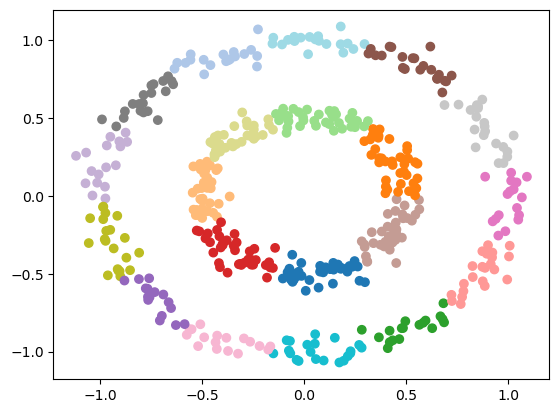

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=prediction_KM, cmap="tab20")

In [4]:
nn_Graph.edges()[(0, 486)]

{'label': 0.0352401238874851}

In [5]:
from matplotlib import colormaps as cm

In [6]:
from clustergraph.utils import get_clusters_from_scikit

cluster_g = cg.ClusterGraph(
    clusters=get_clusters_from_scikit(prediction_KM), X=X, metric_clusters="average"
)

In [7]:
for n in cluster_g.graph.nodes(data=True):
    print(n)

(0, {'size': 36, 'points_covered': array([  3,   4,  25,  30,  37,  63,  97, 114, 115, 120, 136, 137, 138,
       170, 179, 187, 191, 194, 213, 235, 266, 272, 344, 346, 372, 387,
       411, 412, 413, 425, 431, 436, 451, 455, 462, 463])})
(1, {'size': 19, 'points_covered': array([ 44,  60,  69, 102, 142, 165, 189, 255, 260, 299, 308, 338, 347,
       352, 408, 416, 471, 483, 485])})
(2, {'size': 40, 'points_covered': array([  1,   2,  11,  61,  68,  76, 110, 117, 160, 205, 210, 219, 232,
       236, 242, 243, 258, 286, 297, 320, 323, 330, 336, 342, 349, 353,
       358, 383, 395, 405, 417, 420, 423, 430, 438, 452, 457, 470, 489,
       494])})
(3, {'size': 34, 'points_covered': array([ 12,  21,  27,  34,  50,  75,  92,  95, 116, 123, 128, 151, 158,
       173, 234, 245, 264, 265, 270, 281, 298, 317, 326, 334, 351, 367,
       375, 382, 393, 414, 419, 424, 441, 492])})
(4, {'size': 18, 'points_covered': array([ 20,  46,  83,  99, 118, 175, 267, 275, 280, 283, 284, 289, 360,
       374, 

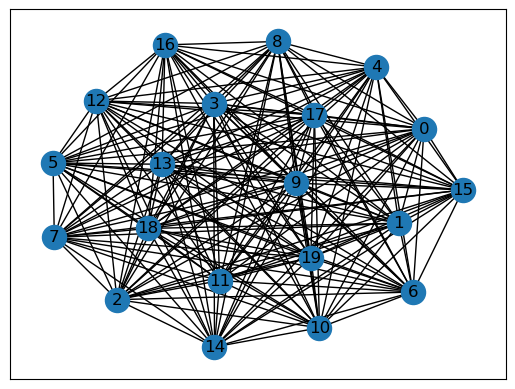

In [8]:
nx.draw_networkx(cluster_g.graph, pos=nx.spring_layout(cluster_g.graph, seed=42))

In [9]:
for e in cluster_g.graph.edges(data=True):
    print(e)

(0, 1, {'label': 1.4716495329810066})
(0, 2, {'label': 0.8058683276199882})
(0, 3, {'label': 0.7819980144972928})
(0, 4, {'label': 0.583830476218566})
(0, 5, {'label': 0.9988539556792679})
(0, 6, {'label': 0.44801455974594473})
(0, 7, {'label': 0.7951425056846418})
(0, 8, {'label': 0.8387884979931468})
(0, 9, {'label': 1.2836904939607587})
(0, 10, {'label': 1.4181937396615911})
(0, 11, {'label': 0.4369297337866359})
(0, 12, {'label': 1.0338035526624403})
(0, 13, {'label': 0.6655628100590324})
(0, 14, {'label': 1.407914078021225})
(0, 15, {'label': 1.2321600000256392})
(0, 16, {'label': 1.0537843470175388})
(0, 17, {'label': 0.9720175721479292})
(0, 18, {'label': 0.5338893273475539})
(0, 19, {'label': 1.4911467559281228})
(1, 2, {'label': 1.084651313278663})
(1, 3, {'label': 0.8674091827266983})
(1, 4, {'label': 1.974548756360414})
(1, 5, {'label': 0.6381770242612664})
(1, 6, {'label': 1.2571068240568954})
(1, 7, {'label': 1.8870315914563691})
(1, 8, {'label': 1.587505278645355})
(1, 9,

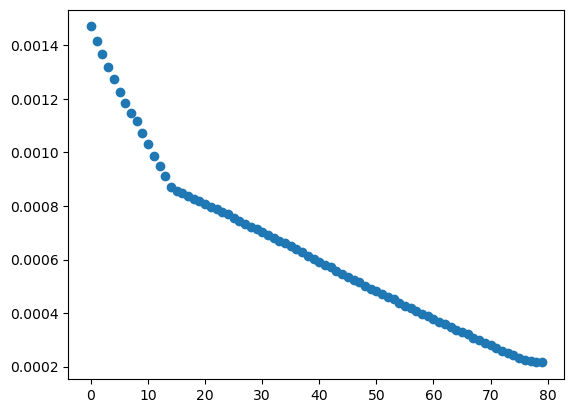

In [12]:
from clustergraph.GraphPruning import GraphPruning

gp = GraphPruning(cluster_g.graph, type_pruning="md", knn_g=nn_Graph, X=X, algo="bf")

pruned_gg, md = gp.prune(score=True)

# plot of the metric distortion evolution
plt.scatter(range(len(md)), md)

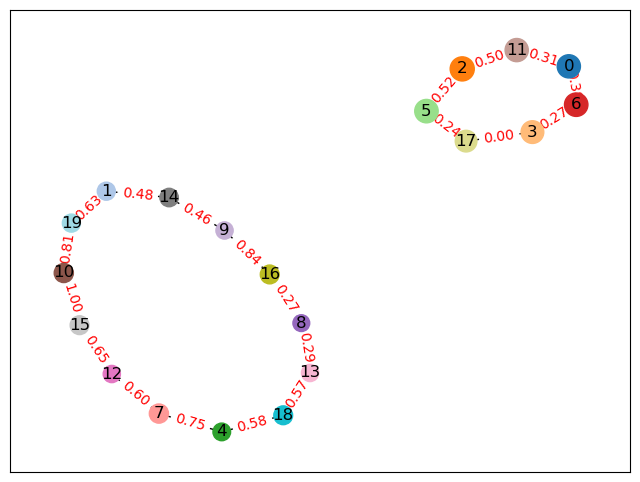

In [13]:
g_prepro = GraphPreprocess(pruned_gg)
g_prepro.fit_nodes(
    type_coloring="label", color_labels=prediction_KM, palette=cm.get_cmap("tab20")
)
g_prepro.fit_edges()
g = g_prepro.graph

import clustergraph.plot_graph as pg

pg.plot_colored_graph(g, nb_edges=len(g.edges), size_nodes=1000)

## Merge components 

In [14]:
%%time
# Creation of the object
cluster_g = cg.ClusterGraph(
    clusters=get_clusters_from_scikit(prediction_KM), X=X, metric_clusters="average"
)

from clustergraph.GraphPruning import GraphPruning
gp = GraphPruning( cluster_g.graph , type_pruning = "md", knn_g= nn_Graph, X=X , algo="bf" ,  k_compo = 3)
pruned_gg , md = gp.prune( score = True)

graph_con = gp.prunedStrategy.conn_prune_merged_graph( pruned_gg, nb_edges_pruned = 10 )
gp.prunedStrategy.plt_conn_prune_computed()

NB  20


KeyError: 'weight'

Plot of the graph with :

1- The metric distortion leading to two disconnected circle

2- Connecting the 3 nearest nodes (in different components) and applying a connectivity pruning only on those edges

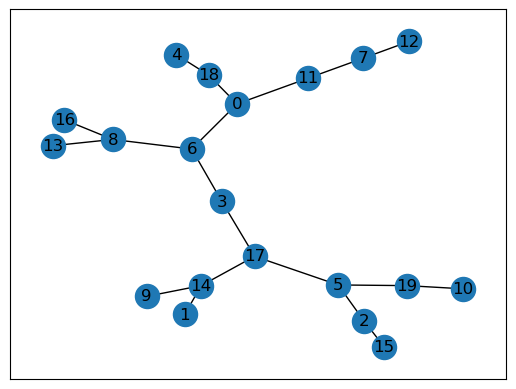

In [23]:
nx.draw_networkx(g)

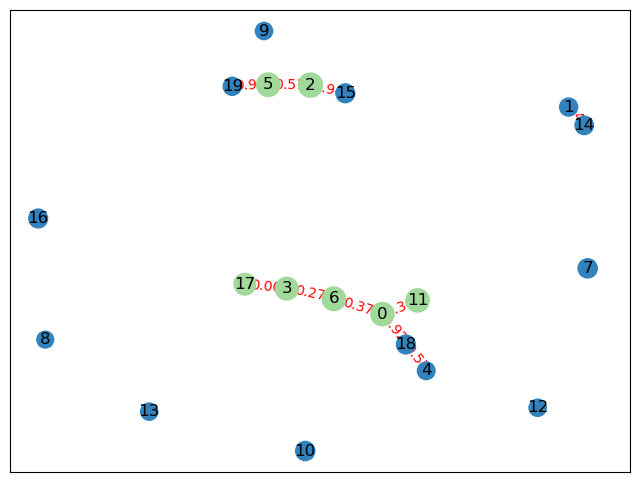

In [19]:
g_prepro = GraphPreprocess(graph_con)
g_prepro.fit_nodes(type_coloring="label", color_labels=labels_circles)
g_prepro.fit_edges()
g = g_prepro.graph

import clustergraph.plot_graph as pg

pg.plot_colored_graph(g, nb_edges=10, size_nodes=1000)